# Denetimsiz (Gözetimsiz) Öğrenme

**Denetimsiz Öğrenme** etiketsiz veriler arasındaki gizli kalmış yapıyı/örüntüyü bulmaya çalışan bir makine öğrenmesi yöntemidir. Burada önemli olan elimizdeki verilerin etiketi hakkında bir bilgimizin olmadığı durumlarda denetimsiz öğrenme kullanılmaktadır. Elimizde sadece veriler vardır ve elimizdeki bu verilerden sonuç çıkarılmaya çalışılmaktadır.

Veriler etiketsiz olduğu için de Denetimsiz Öğrenme algoritması çıktısına kesinlikle doğrudur gözüyle bakmamak gerekir.

Denetimsiz öğrenmede veriler yorumlanarak aralarında bir ilişki bulunur ki buna da İlişkilendirme (Association) problemleri denir veya kümeleştirme işlemi Kümeleme (Clustering) yapılır. Zaten ilk yazımızda da denetimsiz öğrenmenin Kümeleme (Clustering) ve İlişkilendirme (Association) problemlerine uygulandığını söylemiştik.

        1. İlişkilendirme (Association) :

İlişkilendirme algoritması, verileriniz arasındaki birlikteliği ortaya çıkarır. Bu algoritma genelde **Birliktelik Kuralı Madenciliği (Association Rule Mining)** olarak bilinir. İlişkisel veritabanları, işlem veritabanları ve diğer depo biçimleri gibi çeşitli veritabanlarında bulunan veri kümelerinden sık sık meydana gelen kalıpları, bağıntıları veya ilişkileri gözlemlemeyi amaçlayan bir prosedürdür.

        2. Kümeleme (Clustering) :

Kümelenme denetimsiz öğrenmede önemli bir kavramdır. Kümeleme, aynı gruplardaki veri noktalarının aynı gruptaki diğer veri noktalarına daha benzer ve diğer gruplardaki veri noktalarından farklı olacak şekilde birkaç gruba ayırma algoritmasıdır. Temel olarak, verileri aralarındaki benzerlik ve farklılık temelinde analiz ederek gruplara ayırır.

Bu notebook'da değerlendirilecek üç yöntem vardır;

* K - Means (K - Ortalamalar Yöntemi)
* Hiyerarşik Kümeleme Analizi (Hierarchical Cluster Analysis)
* Temel Bileşen Analizi (Principal Component Analysis PCA)

## K - Ortalamalar (K - Means)

Bu yöntemde amacımız, gözlemleri birbirlerine olan benzerliklerinde göre kümelere ayırmaktır.

<p align="center">
  <img src="grafikler/km-1.png" height=400 >
</p>

Sınıflandırma problemlerinde de verimizi sınıflara ayırıyorduk, lakin orada sınıflar belliydi. Çalışmanın başında belli olan sınıflara göre karar kurallarını belirleyip, bu belirlemelerden sonra bir gözlem birimi geldiğinde onun hangi sınıfa ait olduğunu tahmin ediyorduk.

Cluster'ing işleminde ise elimizde bağımlı bir değişken olmadığından dolayı, gözlem birimlerini kendi içerisinde bir birlerine benzerliklerinden dolayı gruplara ayırıyoruz. 

**Adım adım K-ortalamalar kümeleme algoritması nasıl çalışır bakalım:**

1. Küme sayısı belirlenir. (Optimal küme sayısı bulma konusunu birazdan ele alacağız.)

2. Seçilen küme sayısı kadar rastgele küme merkezi (centroid) seçilir.
3. Her gözlem için k merkezlere uzaklıklar hesaplanır.
4. Her bir gözlem en yakın olduğur merkeze yani kümeye atanır.
5. Atama işlemlerinden sonra oluşan kümeler için yeniden merkez hesaplamaları yapılır.
6. Bu işlem **belirlenen bir iterasyon adedince** tekrar edilir ve küme içi hata kareler toplamlarının (total within-cluster variation) minimum olduğu durumdaki gözlemlerin kümelenme yapısı nihai kümeleme olarak seçilir.

Regresyon problemlerinde, amacımız optimum b ve w sayılarını bulmaktı.

Karar ağaçlarında ise optimum karar noktasının neresi olacağını araştırıyorduk.

    Burada ise amacımız; elimizde k tane küme var, bu kümeler kendi içerisinde homojen diğer kümeler ile heterojen olsun istiyoruz. Burada ise önemli nokta doğru merkezi belirlemektir.

Burada kümelerin homojenliği küme içerisindeki SSE'nin (SSR - Sum of Squares of Residuals, veya SSD - um of Squares Distances olarak da adlandırılabilir) en düşük olması ile sağlanmaktadır.

Bu modelin dezavantalarından bir tanesi ise kaç adet küme oluşturulacağıdır. 

### K-Means Uygulama

In [193]:
# Kütüphanelerimizi import edelim;


# pip install yellowbrick

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, SCORERS

pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 10)

In [126]:
# Veri seti problemi;

# Elimizde ABD eyaletlerinin suç istatistikleri bulunmaktadır. Bizler bu eyaletleri belirli sınıflara ayırcağız;
# Bu durum bize segmentasyonu ve RFM'i hatırlatabilir. 
# Burada satın alma değil farklı metriklerden faydalanarak kümeleme ihtiyacı doğmaktadır.

# Veri setimizi okutalım;
df = pd.read_csv("datasets/USArrests.csv", index_col=0)
df

# "index_col=0" argümanı ile verinin 0. sütununu index seç diyoruz.

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9
Georgia,17.4,211,60,25.8


In [127]:
# Eksik değer var mı diye kontrol edelim;

df.isnull().sum()

# Eksik değerimiz yokmuş.

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [128]:
# df'nin infosuna bakalım;

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [129]:
# Verinin betimsel istatistiklerine bakalım;

df.describe().T

# Aykırı bir değer yok gibi.

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.3555097642,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.3376608400,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.4747634008,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.3663845311,7.3,15.075,20.10,26.175,46.0


In [130]:
# Uzaklık temelli bir yöntem kullanacağımız için değişkenleri standartlaştırmamız gerekmektedir;

sc = MinMaxScaler((0, 1))
df = sc.fit_transform(df)
df[0:5]

# Veri, MinMaxScaler()'dan geçince numpy array'ine döndü.
# Çok fazla değişken olmadığı için bunu df içerisine atayıp sütun isimleri düzenlemedik.

array([[0.74698795, 0.65410959, 0.44067797, 0.35917313],
       [0.55421687, 0.74657534, 0.27118644, 0.96124031],
       [0.43975904, 0.85273973, 0.81355932, 0.6124031 ],
       [0.48192771, 0.49657534, 0.30508475, 0.31524548],
       [0.4939759 , 0.79109589, 1.        , 0.86046512]])

In [131]:
# Modelimizi kuralım;

# İçerisine kaç küme istediğimizi söyleyelim ve df'mizi fit edelim;
kmeans = KMeans(n_clusters=4, random_state=17).fit(df)

# hiper parametrelerimizi görelim;
kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 10,
 'random_state': 17,
 'tol': 0.0001,
 'verbose': 0}

In [132]:
# Belirlenen merkezlere bakalım;

kmeans.cluster_centers_

array([[0.1686747 , 0.11485774, 0.34028683, 0.12601868],
       [0.6124498 , 0.75      , 0.75423729, 0.67980189],
       [0.30439405, 0.32937147, 0.70588235, 0.31098951],
       [0.79141566, 0.6802226 , 0.36864407, 0.36466408]])

In [133]:
# Her bir gözlemin kümelerine bakmak istersek;

kmeans.labels_

# 0. indeksteki gözlem 3 kümesine aitmiş, şekilden yorumlayabiliriz.

array([3, 1, 1, 3, 1, 1, 2, 2, 1, 3, 2, 0, 1, 2, 0, 2, 0, 3, 0, 1, 2, 1,
       0, 3, 2, 0, 0, 1, 0, 2, 1, 1, 3, 0, 2, 2, 2, 2, 2, 3, 0, 3, 1, 2,
       0, 2, 2, 0, 0, 2], dtype=int32)

In [134]:
# SSD'ye bakmak istersek, (en yakın cluster'a olan uzaklıkların karelerinin farkı)

kmeans.inertia_

3.6834561535859134

In [135]:
################################
# Optimum Küme Sayısının Belirlenmesi
################################

In [136]:
# Model nesnesini tanımlayalım;

kmeans = KMeans()

# Boş bir liste tanımlayalım;
ssd = []

# Potansiyel k'lar için bir liste tanımlayalım;
K = range(1, 30)

In [137]:
# Bu k'lerde gezecek ve ssd skorlarını kaydedeceğiz;

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=17).fit(df)
    ssd.append(kmeans.inertia_)

ssd

[13.184122550256443,
 6.596893867946196,
 5.010878493006417,
 3.6834561535859134,
 3.1999182085623374,
 2.842666186622827,
 2.631725837655405,
 2.325108770041518,
 2.0686398098410184,
 1.8327104332088633,
 1.6616994084127694,
 1.518394185479906,
 1.3770549513112538,
 1.3148895920096255,
 1.271133650711445,
 1.1578833875407082,
 1.0341984464834657,
 0.9299671485436676,
 0.9208925548828126,
 0.8350853328360585,
 0.7684114698258376,
 0.7496106928018121,
 0.7073985700412031,
 0.6207315225217471,
 0.5611378107893317,
 0.5108547103002283,
 0.4655309280781472,
 0.4430857838274421,
 0.4064751381088188]

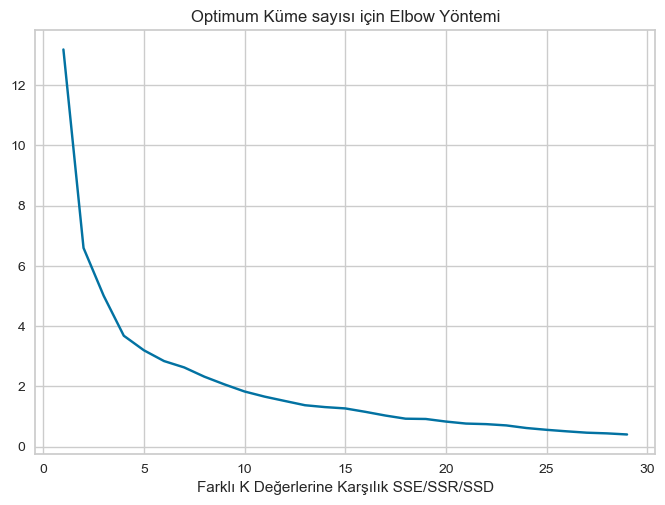

In [138]:
# Bu listenin grafiğini çizdirelim;

plt.plot(K, ssd, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme sayısı için Elbow Yöntemi")
plt.show()

    Yukarıda dikkat edildiğinde cluster sayısı arttıkça SSD değeri düşmektedir. Zaten verimizde 50 adet gözlem bulunmaktadır. Biz 50 adet küme belirlersek, modelimiz over-fit olur.

    Yukarıda dirseklenmenin olduğu yerin 4-5 gibi bir noktada olduğu görülmektedir. Orada eğimin azalma derecesi artık iyice azalmaktadır.

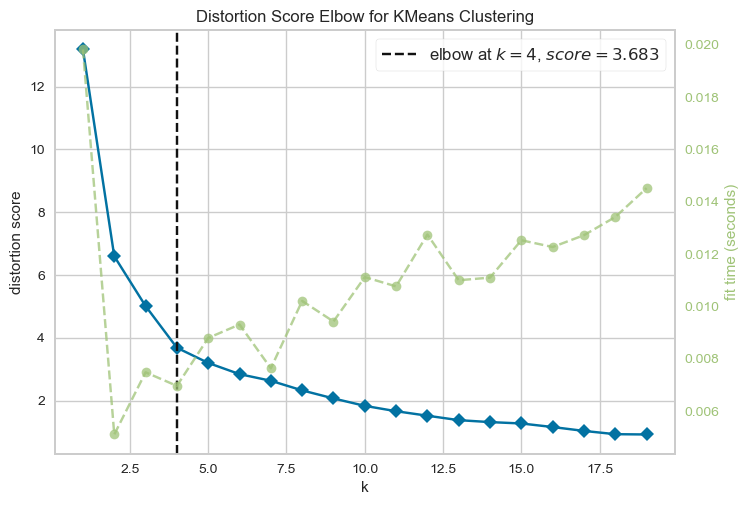

4

In [139]:
# Yukarıdaki bu işlemi daha sistemetik bir şekilde yapalım;

kmeans = KMeans(random_state=17)
elbow = KElbowVisualizer(kmeans, k=(1, 20))
elbow.fit(df)
elbow.show()

elbow.elbow_value_

In [140]:
################################
# Final Cluster'ların Oluşturulması
################################

# Final modeli oluşturalım
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df)

# Kaç cluster olduğuna bakalım;
kmeans.n_clusters
kmeans

KMeans(n_clusters=4)

In [141]:
# Küme merkezlerimize göz atalım;

kmeans.cluster_centers_

array([[0.29254518, 0.32148973, 0.70974576, 0.29667313],
       [0.79141566, 0.6802226 , 0.36864407, 0.36466408],
       [0.1686747 , 0.11485774, 0.34028683, 0.12601868],
       [0.60333642, 0.72734457, 0.74576271, 0.66905188]])

In [142]:
# Gözlemlerimizi label'lerına bakalım;

kmeans.labels_

array([1, 3, 3, 1, 3, 3, 0, 0, 3, 1, 0, 2, 3, 0, 2, 0, 2, 1, 2, 3, 0, 3,
       2, 1, 3, 2, 2, 3, 2, 0, 3, 3, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 3, 0,
       2, 0, 0, 2, 2, 0], dtype=int32)

In [143]:
# Şimdi bu label'leri verimize atayalım;

clusters_kmeans = kmeans.labels_
df = pd.read_csv("datasets/USArrests.csv", index_col=0)
df["cluster"] = clusters_kmeans
df.head()

,Murder,Assault,UrbanPop,Rape,cluster
Alabama,13.2,236,58,21.2,1
Alaska,10.0,263,48,44.5,3
Arizona,8.1,294,80,31.0,3
Arkansas,8.8,190,50,19.5,1
California,9.0,276,91,40.6,3


In [144]:
# Cluster altında gözüken 0 değerleri bizi rahatsı ediyorsa;

df["cluster"] = df["cluster"] + 1

In [145]:
# 4 kümesine ait gözlemleri getirelim;

df[df["cluster"]==4]

,Murder,Assault,UrbanPop,Rape,cluster
Alaska,10.0,263,48,44.5,4
Arizona,8.1,294,80,31.0,4
California,9.0,276,91,40.6,4
Colorado,7.9,204,78,38.7,4
Florida,15.4,335,80,31.9,4
Illinois,10.4,249,83,24.0,4
Maryland,11.3,300,67,27.8,4
Michigan,12.1,255,74,35.1,4
Missouri,9.0,178,70,28.2,4
Nevada,12.2,252,81,46.0,4


In [146]:
# cluster'larımızın betimsel istatisklerine bakalım;

df.groupby("cluster").agg(["count","mean","median"])

Murder                       Assault                        UrbanPop  \
         count           mean median   count            mean median    count   
cluster                                                                        
1           16   5.6562500000   5.95      16  138.8750000000  147.0       16   
2            8  13.9375000000  13.80       8  243.6250000000  242.5        8   
3           13   3.6000000000   2.60      13   78.5384615385   81.0       13   
4           13  10.8153846154  11.10      13  257.3846153846  255.0       13   

                               Rape                        
                  mean median count           mean median  
cluster                                                    
1        73.8750000000   72.5    16  18.7812500000   19.4  
2        53.7500000000   54.0     8  21.4125000000   21.7  
3        52.0769230769   53.0    13  12.1769230769   11.3  
4        76.0000000000   80.0    13  33.1923076923   31.9

## Hiyerarşik Kümeleme Yöntemi (Hierarchical Cluster Analysis)

Bu yöntemde amacımız, gözlemleri birbirlerine olan benzerliklerinde göre hiyerarşik bir şekilde alt kümelere ayırmaktır.

<p align="center">
  <img src="grafikler/hca-1.png" height=400 >
</p>

    Yukarıdaki grafik türüne dendogram denir.

In [147]:
# Uygulama bölümüne geçelim;

# Veri setimizi import edelim;
df = pd.read_csv("datasets/USArrests.csv", index_col=0)

In [148]:
# Uzaklık temelli bir yaklaışım gerçekleştireceğimiz için veri setini standartlaştıralım;

sc = MinMaxScaler((0, 1))
df = sc.fit_transform(df)
df[0:5]

array([[0.74698795, 0.65410959, 0.44067797, 0.35917313],
       [0.55421687, 0.74657534, 0.27118644, 0.96124031],
       [0.43975904, 0.85273973, 0.81355932, 0.6124031 ],
       [0.48192771, 0.49657534, 0.30508475, 0.31524548],
       [0.4939759 , 0.79109589, 1.        , 0.86046512]])

In [149]:
# Aşağıda birleştirici bir clustering yöntemi olan linkage yöntemini kullanalım;
# Detaylı bilgi için "linkage" ifadesinin üzerine tıklayıp, daha sonra command'e basarak bir kez daha tıklarsanız,
# metodun detaylarını görebilirsiniz.

hc_average = linkage(df, "average")

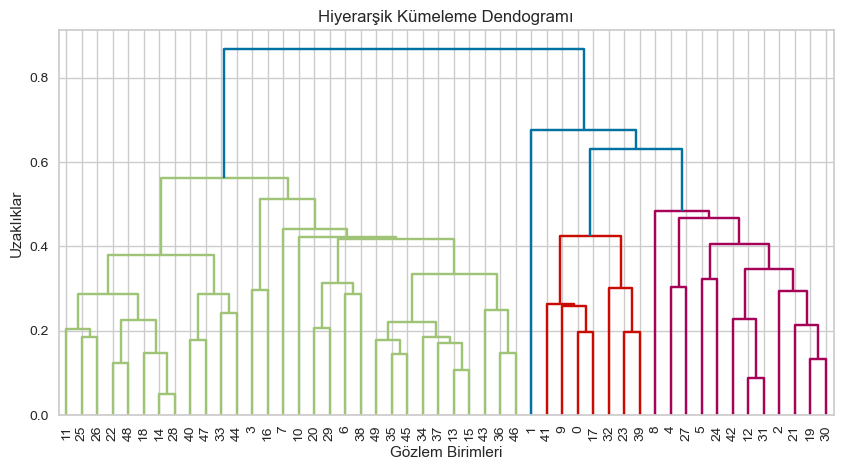

In [150]:
# Çalıştırdığımız yöntemin dendogramını çıkartalım;

plt.figure(figsize=(10, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_average,
           leaf_font_size=10)
plt.show()

        Bu yöntemin avantajı gözlem birimlerine yukarıdan bakılmasını sağlamaktadır.

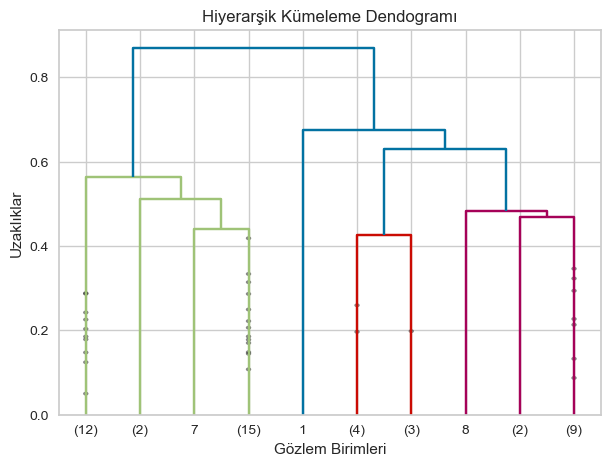

In [151]:
# dendogram fonksiyonunun içerisine argüma girerek daha sade bir görsel da oluşturmak mümkündür;

plt.figure(figsize=(7, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

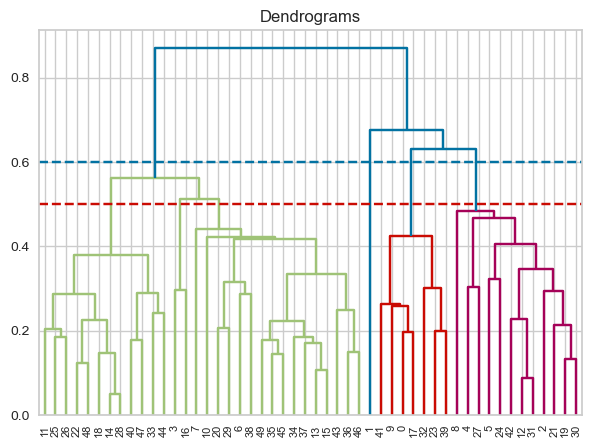

In [152]:
################################
# Kume Sayısını Belirlemek
################################

# Yukarıdaki grafiğe baktığımızda grafiğin y ekseninde Euclide uzaklığı vardır.
# Bu uzaklıktaki tresh hold değerimiz bize kaç tane alt cluster olduğunu söyleyecek.

# Görselleştirelim;

plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_average)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axhline(y=0.6, color='b', linestyle='--')
plt.show()

Tresh hold'umuzu 0.5 alırsak 6 adet, 0.6 alırsak 4 adet alt cluster oluşur.

In [153]:
################################
# Final Modeli Oluşturmak
################################

# İlgili metodumuzu import edelim;
from sklearn.cluster import AgglomerativeClustering


# Burada modelimize kaç adet alt sınır istediğimizi hangi yönteme göre estimation yapmasını istediğimizi söylüyoruz.

cluster = AgglomerativeClustering(n_clusters=4, linkage="average")

# 5 alt cluster istediğimizi ve linkage yöntemine göre model kurmasını istediğimizi ifade ettik.

# Şimdi gözlemlerimizin hangi cluster'da olduğunu belirleyelim;
clusters = cluster.fit_predict(df)
clusters

array([3, 2, 1, 0, 1, 1, 0, 0, 1, 3, 0, 0, 1, 0, 0, 0, 0, 3, 0, 1, 0, 1,
       0, 3, 1, 0, 0, 1, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 1, 0,
       0, 0, 0, 0, 0, 0])

In [154]:
# Belirlediğimiz cluster'ları atayalım;

df = pd.read_csv("datasets/USArrests.csv", index_col=0)
df["hi_cluster_no"] = clusters

df["hi_cluster_no"] = df["hi_cluster_no"] + 1
df

,Murder,Assault,UrbanPop,Rape,hi_cluster_no
Alabama,13.2,236,58,21.2,4
Alaska,10.0,263,48,44.5,3
Arizona,8.1,294,80,31.0,2
Arkansas,8.8,190,50,19.5,1
California,9.0,276,91,40.6,2
Colorado,7.9,204,78,38.7,2
Connecticut,3.3,110,77,11.1,1
Delaware,5.9,238,72,15.8,1
Florida,15.4,335,80,31.9,2
Georgia,17.4,211,60,25.8,4


In [155]:
# K-means clusterlarını da ekleyelim;

df["kmeans_cluster_no"] = clusters_kmeans
df["kmeans_cluster_no"] = df["kmeans_cluster_no"]  + 1
df

,Murder,Assault,UrbanPop,Rape,hi_cluster_no,kmeans_cluster_no
Alabama,13.2,236,58,21.2,4,2
Alaska,10.0,263,48,44.5,3,4
Arizona,8.1,294,80,31.0,2,4
Arkansas,8.8,190,50,19.5,1,2
California,9.0,276,91,40.6,2,4
Colorado,7.9,204,78,38.7,2,4
Connecticut,3.3,110,77,11.1,1,1
Delaware,5.9,238,72,15.8,1,1
Florida,15.4,335,80,31.9,2,4
Georgia,17.4,211,60,25.8,4,2


In [156]:
df.groupby("kmeans_cluster_no").agg(["count","mean","median"])

Murder                       Assault                         \
                   count           mean median   count            mean median   
kmeans_cluster_no                                                               
1                     16   5.6562500000   5.95      16  138.8750000000  147.0   
2                      8  13.9375000000  13.80       8  243.6250000000  242.5   
3                     13   3.6000000000   2.60      13   78.5384615385   81.0   
4                     13  10.8153846154  11.10      13  257.3846153846  255.0   

                  UrbanPop                        Rape                        \
                     count           mean median count           mean median   
kmeans_cluster_no                                                              
1                       16  73.8750000000   72.5    16  18.7812500000   19.4   
2                        8  53.7500000000   54.0     8  21.4125000000   21.7   
3                       13  52.0769230769   53.0    13  12.1769230769   11.3   
4                       13  76.0000000000   80.0    13  33.1923076923   31.9   

                  hi_cluster_no                       
                          count          mean median  
kmeans_cluster_no                                     
1                            16  1.0000000000    1.0  
2                             8  3.6250000000    4.0  
3                            13  1.0000000000    1.0  
4                            13  2.0769230769    2.0

In [157]:
df.groupby("hi_cluster_no").agg(["count","mean","median"])

Murder                       Assault                         \
               count           mean median   count            mean median   
hi_cluster_no                                                               
1                 30   4.8700000000   4.65      30  114.4333333333  111.5   
2                 12  10.8833333333  11.20      12  256.9166666667  254.5   
3                  1  10.0000000000  10.00       1  263.0000000000  263.0   
4                  7  14.6714285714  14.40       7  251.2857142857  249.0   

              UrbanPop                        Rape                        \
                 count           mean median count           mean median   
hi_cluster_no                                                              
1                   30  63.6333333333   65.5    30  15.9433333333  16.05   
2                   12  78.3333333333   80.0    12  32.2500000000  31.45   
3                    1  48.0000000000   48.0     1  44.5000000000  44.50   
4                    7  54.2857142857   58.0     7  21.6857142857  22.20   

              kmeans_cluster_no              
                          count mean median  
hi_cluster_no                                
1                            30  1.9    1.0  
2                            12  4.0    4.0  
3                             1  4.0    4.0  
4                             7  2.0    2.0

## Temel Bileşen Analizi (Principal Component Analysis - PCA)

Bu yöntemdeki temel fikir, çok değişkenli verinin ana özelliklerini daha az sayıda değişken/bileşen ile temsil etmektir. Bir başka şekilde ifade etmek istersek; küçük bir miktarda bilgi kaybını göze alıp değişken boyutunu azaltmaktır.

Aklımızda daha iyi canlansın diye aşağıda bulunan görseldeki gibi bir modelleme olsun;

<p align="center">
  <img src="grafikler/pca-1.png" height=400 >
</p>

Orjinal Data Space'e bakıldığında 3 boyutlu olduğu görülüyor, bunu iki boyuta indirgeme işlemi PCA ile yapılır.


In [158]:
# Uygulama Bölümü

# Verimizi import edelim;

df = pd.read_csv("datasets/Hitters.csv")
df.head()

# Bu veri seti beyzbol oyuncularının istatistiklerinin bulunduğu ve 
# bu istatistikler neticesinde oyuncuların maaş tahminin yapıldığı bir veri setidir.

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [159]:
# Veri setindeki sayısal değişkenleri yakalayalım ve bağımlı değişkeni çıkaralım;

num_cols = [col for col in df.columns if df[col].dtypes != "O" and "Salary" not in col]

# Veri setindeki numerik değişkenlere bakalım;
df[num_cols].head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4


In [160]:
# Verimizde sadece numerik değişkenler kalsın istiyoruz;
df = df[num_cols]

# "NaN" değerleri drop edelim;
df.dropna(inplace=True)

# Verinin shape'sine bakalım;
df.shape

(322, 16)

        Amacımız 16 değişkenli bu veriyi 2 ve 3 değişkene indirgemek olacak.

In [161]:
# Bu yöntemde de verinin değişkenlerini scale etmemiz gerekmektedir;
df = StandardScaler().fit_transform(df)

df[0:2]

array([[-0.57407148, -0.75512977, -1.12359063, -0.80473431, -0.72830827,
        -1.14517175, -1.31019382, -1.01512078, -0.99711664, -0.79518275,
        -0.98563596, -0.9050688 , -0.92347844,  0.56039893, -0.54092397,
         1.88089921],
       [-0.43043703, -0.43173229, -0.43357884, -1.03564872, -0.3838269 ,
         0.01193037,  1.3329249 ,  0.34487582,  0.17970399, -0.00569687,
        -0.11329898,  0.25212364,  0.43039134,  1.2240485 , -0.46774014,
         0.308192  ]])

In [162]:
# PCA() model nesnemizi tanımlayalım;
pca = PCA()

# Verimizi modelden geçirelim;
pca_fit = pca.fit_transform(df)

PCA yöntemi, **yüksek korelasyonlu değişkenleri bir araya getirerek**, verilerdeki en çok varyasyonu oluşturan “temel bileşenler” olarak adlandırılan daha az sayıda yapay değişken kümesi oluşturur.

In [163]:
pca.explained_variance_ratio_

array([4.60378552e-01, 2.60398491e-01, 1.03388605e-01, 5.36902121e-02,
       4.20784091e-02, 2.96359092e-02, 1.57079101e-02, 1.13928108e-02,
       7.83230398e-03, 5.87669497e-03, 3.74765194e-03, 3.09384056e-03,
       1.55679403e-03, 8.59034766e-04, 2.86873704e-04, 7.59064046e-05])

    Yukarıda her bir değişkenin varyans oranlarını görüyoruz. Buradaki yaklaşımımız şöyle olacaktır; ben öyle değişkenler seçmeliyim ki, seçtiğim değişkenlerin varyans toplamları veri setinin varyansına yakın olsun.

array([0.46037855, 0.72077704, 0.82416565, 0.87785586, 0.91993427,
       0.94957018, 0.96527809, 0.9766709 , 0.9845032 , 0.9903799 ,
       0.99412755, 0.99722139, 0.99877819, 0.99963722, 0.99992409,
       1.        ])

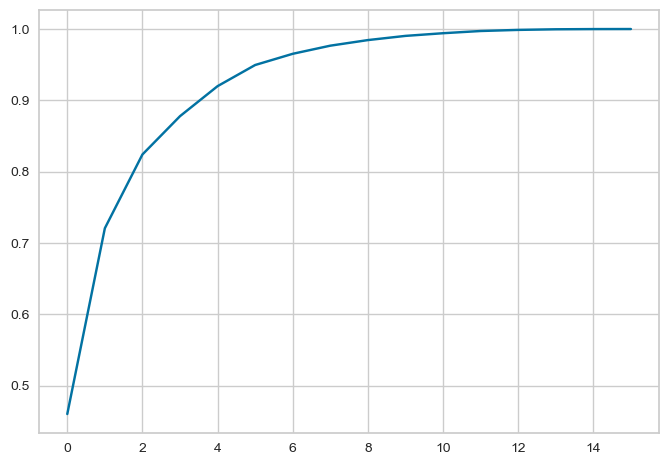

In [167]:
# Yukarıda söylediğimiz ifadeyi bir görselle de destekleyelim;

# Bu varyans oranlarını kümülatif bir şekilde toplayalım;
plt.plot(np.cumsum(pca.explained_variance_ratio_))
np.cumsum(pca.explained_variance_ratio_)

Yukarıda hem grafiği hem de kümülatif toplanarak giden array'i görüyoruz.

    Bunu şu şekilde yorumlayacağız, birinci değişken veri setinin 0.46'sını tek başına açıklıyor. 10. değişkenden sonra açıklanma oranı 0.99'da kalmış, ta ki 16. değişkene kadar.

#### OPTİMUM BİLEŞEN SAYISI

Burada yine elbow yöntemini kullanacağız. PCA yöntemini eğer ki görselleştirme için kullanacaksak zaten 2 bileşen seçmek zorundayız. Yine de biz yukarıdaki örnekten yola çıkacak olursak;

3 değişken ile verinin %80'den daha fazlasını, 4 değişken ile ise %87'den fazlasını açıklıyoruz. Bizim geliştirici olarak burada 3 veya 4 değişkene indirmeyi tercih ediyor olmamız gerekebilir. İhtiyaçlar doğrultusunda bu sayı tabiki değişebilir.

In [168]:
################################
# Final PCA'in Oluşturulması
################################

pca = PCA(n_components=3)
pca_fit = pca.fit_transform(df)

In [169]:
# varyanslara bakalım;
pca.explained_variance_ratio_

array([0.46037855, 0.26039849, 0.1033886 ])

In [170]:
# Kümülatif varyanslara bakalım;
np.cumsum(pca.explained_variance_ratio_)

array([0.46037855, 0.72077704, 0.82416565])

        Bölüm (PCA) başında  ifade ettiğimiz bir miktar bilgi kaybını göz alarak ifadesinin karşılığı burasıdır.

In [171]:
################################
# BONUS: Principal Component Regression
################################

Diyelim ki hitters, veri seti doğrusal bir regresyon modeli ile modellenmek isteniyor ve değişkenler arasında çoklu bağlantı problemi olduğunu ön görüyoruz. (Yani değişkenler arasında yüksek korelasyon olabileceğini düşünüyoruz.)

In [172]:
# Veri setimizi bir kez daha okutalım;
df = pd.read_csv("datasets/Hitters.csv")

# Verinin shape'sine bakalım;
df.shape

(322, 20)

In [173]:
# pca_fit'teki gözlem sayısına bakalım;

len(pca_fit)

322

Ezbere de gitmeyelim, bir önceki kısımda boş değerleri drop etmiştik, lakin verideki boş değerlerin tamamı "salary" değişkeninden kaynaklanmaktadır. num_cols'u seçerken salary'i dışarda bırakmıştık bu sebeple, her iki veri setinde de 322 gözlem bulunmkatadır.

In [176]:
# Numerik değişkenler bir kez daha seçelim ve kaç numerik değişken var bakalım;
num_cols = [col for col in df.columns if df[col].dtypes != "O" and "Salary" not in col]
len(num_cols)

16

In [178]:
# Numerik değişken dışında kalan sütunları da bir liste içerisine kaydedelim;
others = [col for col in df.columns if col not in num_cols]
others

['League', 'Division', 'Salary', 'NewLeague']

In [179]:
# 16 değişkeni bir önceki bölümde 3 değişkene indirgemiştik, bu 3 değişkenden bir dataframe oluşturalım;
pd.DataFrame(pca_fit, columns=["PC1","PC2","PC3"]).head()

,PC1,PC2,PC3
0,-3.2401064151,-0.2531730032,0.7760658463
1,0.2454879516,1.3029506529,0.1180397083
2,0.6038833802,-2.6170016246,-0.6981830376
3,3.5912756772,0.5478210884,-1.0490216764
4,-2.2645283306,-0.6988982393,-1.2905361194


In [180]:
# df others'a bakalım;

df[others].head()

,League,Division,Salary,NewLeague
0,A,E,NaN,A
1,N,W,475.0,N
2,A,W,480.0,A
3,N,E,500.0,N
4,N,E,91.5,N


In [181]:
# Şimdi bu iki dataframe'i birleştirelim;

final_df = pd.concat([pd.DataFrame(pca_fit, columns=["PC1","PC2","PC3"]),
                      df[others]], axis=1)
final_df.head()

,PC1,PC2,PC3,League,Division,Salary,NewLeague
0,-3.2401064151,-0.2531730032,0.7760658463,A,E,NaN,A
1,0.2454879516,1.3029506529,0.1180397083,N,W,475.0,N
2,0.6038833802,-2.6170016246,-0.6981830376,A,W,480.0,A
3,3.5912756772,0.5478210884,-1.0490216764,N,E,500.0,N
4,-2.2645283306,-0.6988982393,-1.2905361194,N,E,91.5,N


In [182]:
# Model kurulumuna geçeceğiz, kütüphanelerimizi import edelim;

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [183]:
# Lakin kategorik değişkenleri encode etmemiz gerekmektedir;

# Label encoder değişkenimizi tanımlayalım;
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [184]:
# Değişkenlerimizi encode edelim;
for col in ["NewLeague", "Division", "League"]:
    label_encoder(final_df, col)

In [185]:
# Final df'e göz atalım;
final_df

,PC1,PC2,PC3,League,Division,Salary,NewLeague
0,-3.2401064151,-0.2531730032,0.7760658463,0,0,NaN,0
1,0.2454879516,1.3029506529,0.1180397083,1,1,475.0,1
2,0.6038833802,-2.6170016246,-0.6981830376,0,1,480.0,0
3,3.5912756772,0.5478210884,-1.0490216764,1,0,500.0,1
4,-2.2645283306,-0.6988982393,-1.2905361194,1,0,91.5,1
...,...,...,...,...,...,...,...
317,-0.0895027412,-0.5210499353,-0.7707206381,1,0,700.0,1
318,3.3398106474,-0.7327126516,3.1141938686,0,0,875.0,0
319,-0.9514415685,-0.9100862294,0.2865173044,0,1,385.0,0
320,2.0914732190,-2.2658264567,-0.1927451297,0,0,960.0,0


In [186]:
# Salary'de boş değerler var onları veri setinden çıkartalım;

final_df.dropna(inplace=True)

In [187]:
# Bağımlı ve bağımsız değişkenlerimizi belirleyelim;

y = final_df["Salary"]
X = final_df.drop(["Salary"], axis=1)

In [208]:
# Model nesnemizi çağıralım;

lm = LinearRegression()

# CV yapalım

cv_results = cross_validate(lm, X, y, cv=5, scoring=["neg_mean_absolute_percentage_error"])

In [210]:
# CV sonucuna göre hata metriğimize bakalım;

-cv_results["test_neg_mean_absolute_percentage_error"].mean()

0.7477865066605174

        Bu veri için çok da iyi bir sonuç veremedi, zira MAPE 0.747 çıktı.

In [211]:
# Bir de karar ağacı ile bakalım;

cart = DecisionTreeRegressor()

cv_results = cross_validate(cart, X, y, cv=5, scoring=["neg_mean_absolute_percentage_error"])

In [212]:
# CV sonucuna göre hata metriğimize bakalım;

-cv_results["test_neg_mean_absolute_percentage_error"].mean()

0.5762917853866132

    Hiper parametre optimizasyonu yapmadan linear regression'a göre iyi bir noktadayız.

In [213]:
# Optimizasyon için basit bir hiper parametre ızgarası belirleyelim;

cart_params = {'max_depth': range(1, 11),
               "min_samples_split": range(2, 20)}

# GridSearchCV ile hiper parametre aramamıza başlayalım;
cart_best_grid = GridSearchCV(cart,
                              cart_params,
                              cv=5,
                              n_jobs=-1,
                              verbose=True).fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [214]:
# En iyi hiper parametrelere bakalım;

cart_best_grid.best_params_

{'max_depth': 3, 'min_samples_split': 19}

In [215]:
# Final modelimizi kuralım;

cart_final = DecisionTreeRegressor(**cart_best_grid.best_params_, random_state=17).fit(X, y)

# Final modelinde 5 katlı CV yapalım;

cv_results = cross_validate(cart_final, X, y, cv=5, scoring=["neg_mean_absolute_percentage_error"])

In [216]:
# Final modeline ait CV'nin hata metriğini inceleyelim;

-cv_results["test_neg_mean_absolute_percentage_error"].mean()

0.6274259655077363

        ?????

In [217]:
################################
# BONUS: PCA ile Çok Boyutlu Veriyi 2 Boyutta Görselleştirme
################################

In [218]:
################################
# Breast Cancer
################################

In [219]:
# pandas ayarlamalarımızı yapalım;

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [221]:
# Veri setimizi okutalım;

df = pd.read_csv("datasets/breast_cancer.csv")
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Veri setimizde bir çok değişken olmasının yanı sıra, bağımlı değişkenimiz "diagnosis" değişkenidir. "diagnosis" değişkeni bize tümör'ün iyi huylu olup olmadığını söyler.

In [222]:
# Bağımlı ve bağımsız değişkenlerimizi tanımlayalım;

y = df["diagnosis"]
X = df.drop(["diagnosis", "id"], axis=1)

In [223]:
# Veri setimizi 2 değişkene indirgeyecek bir fonksiyon tanımlayalım;

def create_pca_df(X, y):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    pca_fit = pca.fit_transform(X)
    pca_df = pd.DataFrame(data=pca_fit, columns=['PC1', 'PC2'])
    final_df = pd.concat([pca_df, pd.DataFrame(y)], axis=1)
    return final_df

In [225]:
# Veri setimizi tanımladığımız bu fonksiyondan geçirelim;

pca_df = create_pca_df(X, y)
pca_df

,PC1,PC2,diagnosis
0,9.1928368262,1.9485830708,M
1,2.3878017958,-3.7681717419,M
2,5.7338962797,-1.0751737966,M
3,7.1229531977,10.2755891219,M
4,3.9353020737,-1.9480715678,M
...,...,...,...
564,6.4393154840,-3.5768174440,M
565,3.7933823700,-3.5840478639,M
566,1.2561792762,-1.9022967131,M
567,10.3747940598,1.6720101051,M


In [226]:
# Yukarıdaki tabloyu görselleştirecek bir fonksiyon tanımlayalım;

def plot_pca(dataframe, target):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('PC1', fontsize=15)
    ax.set_ylabel('PC2', fontsize=15)
    ax.set_title(f'{target.capitalize()} ', fontsize=20)

    targets = list(dataframe[target].unique())
    colors = random.sample(['r', 'b', "g", "y"], len(targets))

    for t, color in zip(targets, colors):
        indices = dataframe[target] == t
        ax.scatter(dataframe.loc[indices, 'PC1'], dataframe.loc[indices, 'PC2'], c=color, s=50)
    ax.legend(targets)
    ax.grid()
    plt.show()

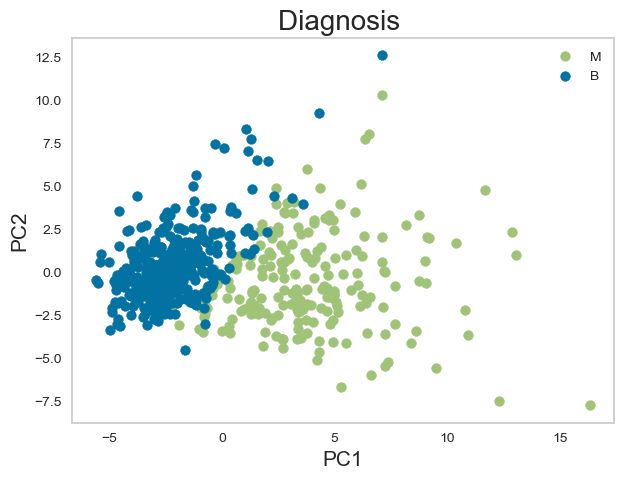

In [227]:
# Görselleştirme işlemini yapalım;

plot_pca(pca_df, "diagnosis")

#### Yukarıdaki işlemi IRIS veri seti için de uygulayalım;

In [228]:
import seaborn as sns
df = sns.load_dataset("iris")
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [229]:
y = df["species"]
X = df.drop(["species"], axis=1)

# Bağımsız değişkenin içerisinde kategorik veri olmamalı, hepsi numerik olmalıdır.

In [230]:
pca_df = create_pca_df(X, y)
pca_df

,PC1,PC2,species
0,-2.2647028088,0.4800265965,setosa
1,-2.0809611520,-0.6741335566,setosa
2,-2.3642290539,-0.3419080239,setosa
3,-2.2993842170,-0.5973945077,setosa
4,-2.3898421663,0.6468353829,setosa
...,...,...,...
145,1.8705032930,0.3869660817,virginica
146,1.5645804830,-0.8966868089,virginica
147,1.5211704996,0.2690691443,virginica
148,1.3727877895,1.0112544185,virginica


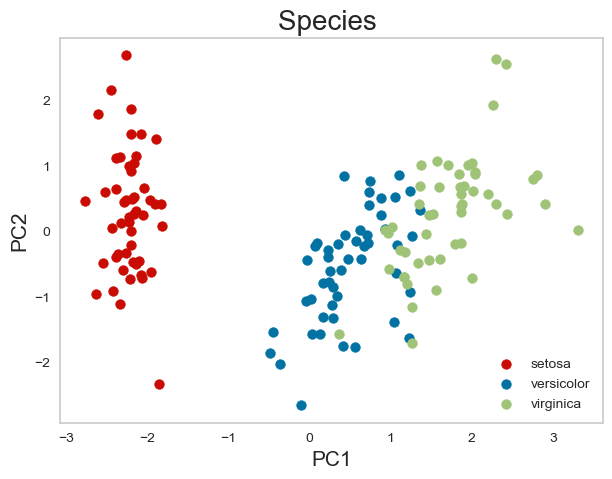

In [231]:
# Görselleştirelim;
plot_pca(pca_df, "species")

#### Diabet veri seti için de yapalım;

In [232]:
# Veri setimizi çağıralım;

df = pd.read_csv("datasets/diabetes.csv")

In [233]:
# Bağımlı ve bağımsız değişkenlerimizi belirleyelim;

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [234]:
pca_df = create_pca_df(X, y)

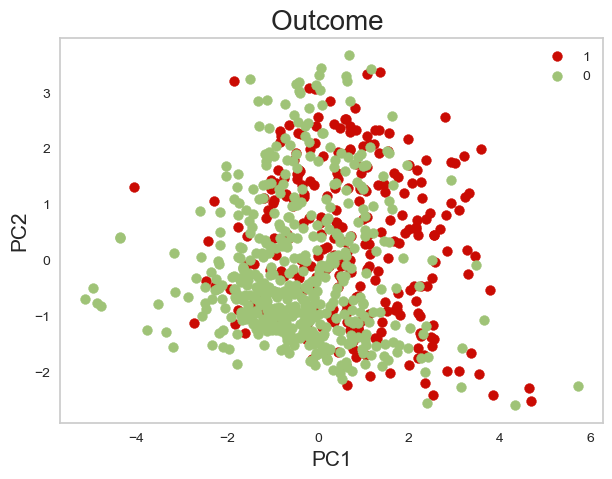

In [235]:
# Görselleştirelim;
plot_pca(pca_df, "Outcome")
